In [588]:
import gymnasium as gym  # Defines RL environments

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (4,4)  # Set size of visualization
from IPython.display import clear_output  # For inline visualization

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import cma
from math import prod

# Define task
env = gym.make('CartPole-v1')
state_space_dimension = env.observation_space.shape[0]
action_space_dimension = 1  # env.action_space.n - 1

In [589]:
# Model definition
class Policy(nn.Module):
    def __init__(self, state_space_dimension, action_space_dimension, num_neurons=5, bias = False):
        super(Policy, self).__init__()
        self.fc = nn.Linear(state_space_dimension, num_neurons, bias=bias)
        self.fc1 = nn.Linear(num_neurons, action_space_dimension, bias=bias)

    def forward(self, x):
        hidden = torch.tanh(self.fc(x))
        output = self.fc1(hidden)
        return output

policy_net = Policy(state_space_dimension, action_space_dimension)


In [590]:
#This just comes from the CMA assignment
def fitness_cart_pole(x, nn, env):
    '''
    Returns negative accumulated reward for single pole, fully environment.

    Parameters:
        x: Parameter vector encoding the weights.
        nn: Parameterized model.
        env: Environment ('CartPole-v?').
    '''
    torch.nn.utils.vector_to_parameters(torch.Tensor(x), nn.parameters())  # Set the policy parameters
    
    state = env.reset()  # Forget about previous episode
    state_tensor = torch.Tensor( state[0].reshape((1, state_space_dimension)) )
          
    R = 0  # Accumulated reward
    while True:
        out = nn(state_tensor)
        a = int(out > 0)
        state, reward, terminated, truncated, _ = env.step(a)  # Simulate pole
        state_tensor = torch.Tensor( state.reshape((1, state_space_dimension)) )
        R += reward  # Accumulate 
        if truncated:
            return -1000  # Episode ended, final goal reached, we consider minimization
        if terminated:
            return -R  # Episode ended, we consider minimization
    return -R  # Never reached  

In [ ]:
#Only used for evaluating the model performance
def step_policy(policy_net):
    trajectory_features = []  # Store the features of the trajectory
    env_render = gym.make('CartPole-v1', render_mode='rgb_array', max_episode_steps=5000)
    state = env_render.reset()  # Forget about previous episode
    state_tensor = torch.Tensor( state[0].reshape((1, state_space_dimension)) )
    steps = 0
    while True:
        out = policy_net(state_tensor)
        a = int(out > 0)
        state, reward, terminated, truncated, _ = env_render.step(a)  # Simulate pole
        steps+=1
        state_tensor = torch.Tensor( state.reshape((1, state_space_dimension)) )
        trajectory_features.append(state_tensor.detach().numpy()[0])
        if(terminated or truncated): 
            break
        
    env_render.close()
    return steps, trajectory_features  # Return the number of steps and the trajectory features

" def step_policy(policy_net):\n    trajectory_features = []  # Store the features of the trajectory\n    env_render = gym.make('CartPole-v1', render_mode='rgb_array', max_episode_steps=5000)\n    state = env_render.reset()  # Forget about previous episode\n    state_tensor = torch.Tensor( state[0].reshape((1, state_space_dimension)) )\n    steps = 0\n    while True:\n        out = policy_net(state_tensor)\n        a = int(out > 0)\n        state, reward, terminated, truncated, _ = env_render.step(a)  # Simulate pole\n        steps+=1\n        state_tensor = torch.Tensor( state.reshape((1, state_space_dimension)) )\n        trajectory_features.append(state_tensor.detach().numpy()[0])\n        if(terminated or truncated): \n            break\n        \n    env_render.close()\n    return steps, trajectory_features  # Return the number of steps and the trajectory features "

In [ ]:
#Again, just comes from the assignment
def train_agent():     
    policy_net = Policy(state_space_dimension, action_space_dimension)
    d = sum(param.numel() for param in policy_net.parameters())
    initial_weights = np.random.normal(0, 0.01, d)  # Random parameters for initial policy, d denotes the number of weights
    initial_sigma = .01 # Initial global step-size sigma
    # Do the optimization
    res = cma.fmin(fitness_cart_pole,  # Objective function
                initial_weights,  # Initial search point
                initial_sigma,  # Initial global step-size sigma
                args=([policy_net, env]),  # Arguments passed to the fitness function
                options={'ftarget': -9999.9, 'tolflatfitness':1000, 'eval_final_mean':False})
    env.close()
  
    # Set the policy parameters to the final solution
    torch.nn.utils.vector_to_parameters(torch.Tensor(res[0]), policy_net.parameters())      

    return policy_net, res[2]  # Return the number of steps and the policy network

In [593]:
def get_performance(policy_net, no_runs = 10): 
    pole_bal_unbiased = []
    trajectories = []  # Store the features of the trajectories
    
    for _ in range(no_runs):     

        steps, trajectory_features = step_policy(policy_net)
        
        pole_bal_unbiased.append(steps)  # Store the number of steps in the pole balancing task
        trajectories+=trajectory_features
        
    return pole_bal_unbiased, np.array(trajectories)

In [ ]:
policy_net, eval_steps = train_agent() #Here we train the agent, and report the evaluation steps

(6_w,13)-aCMA-ES (mu_w=4.0,w_1=38%) in dimension 25 (seed=461772, Mon Mar 31 13:54:36 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     13 -2.020000000000000e+02 1.0e+00 9.27e-03  9e-03  9e-03 0:00.1
    2     26 -4.660000000000000e+02 1.1e+00 9.19e-03  9e-03  9e-03 0:00.2
    3     39 -1.000000000000000e+03 1.1e+00 9.08e-03  9e-03  9e-03 0:00.3
   14    182 -1.000000000000000e+03 1.4e+00 8.51e-03  8e-03  9e-03 0:03.7
   27    351 -1.000000000000000e+03 1.7e+00 8.66e-03  8e-03  9e-03 0:07.9
   41    533 -1.000000000000000e+03 1.8e+00 8.38e-03  8e-03  9e-03 0:13.0
   55    715 -1.000000000000000e+03 2.1e+00 9.76e-03  9e-03  1e-02 0:19.2
   71    923 -1.000000000000000e+03 2.3e+00 8.60e-03  8e-03  1e-02 0:26.4
termination on tolfun=1e-11 (Mon Mar 31 13:55:02 2025)
termination on tolfunhist=1e-12 (Mon Mar 31 13:55:02 2025)
final/bestever f-value = -1.000000e+03 -1.000000e+03 after 923/29 evaluations
incumbent solution: [-0.03743545 -0.04255964  0.0753

In [ ]:
pole_bal_unbiased, trajectories = get_performance(policy_net, 20) #Running the agent for 20 times, and storing the results

In [ ]:
print("The average number of steps with max_steps = 5000, is: ", np.mean(pole_bal_unbiased))

The number of evaluations is:  29
The average number of steps with max_steps = 5000, is:  491.0


In [ ]:
#Define the Neural Conditioner, which comes from this paper: https://arxiv.org/pdf/1902.08401
#It is a basically a variational autoencoder with GAN-like training, where the generator is a neural conditioner, and the discriminator is a neural network that tries to distinguish between real and fake data.
class NeuralConditioner(nn.Module):
    def __init__(self, input_dim=4, latent_dim=64):
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        
        # Encoder: [x_a (4) + a (4) + r (4)] = 12 dim input
        self.encoder = nn.Sequential(
            nn.Linear(12, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        
        # Decoder: [z (latent_dim) + x_a (4) + a (4) + r (4)] = latent_dim + 12
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + 12, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )
    
    def forward(self, x_a, a, r, z):
        # Input shapes should be: [batch_size, 4] for x_a, a, r
        # z shape: [batch_size, latent_dim]
        encoder_input = torch.cat([x_a, a, r], dim=1)
        h = self.encoder(encoder_input)
        
        decoder_input = torch.cat([h, x_a, a, r], dim=1)  # Use encoded h instead of raw z
        return self.decoder(decoder_input) * r

class Discriminator(nn.Module):
    def __init__(self, input_dim=4):
        super().__init__()
        # Input: [x_r (4) + x_a (4) + a (4) + r (4)] = 16 dim
        self.net = nn.Sequential(
            nn.Linear(16, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x_r, x_a, a, r):
        inputs = torch.cat([x_r, x_a, a, r], dim=1)
        return self.net(inputs)

#Training Function
def train_nc(nc, discriminator, dataloader, epochs):
    nc.train()
    discriminator.train()
    
    opt_nc = torch.optim.Adam(nc.parameters(), lr=1e-4)
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
    
    for epoch in range(epochs):
        for x_real in dataloader:
            batch_size = x_real.size(0)
            
            # Create random masks
            a = torch.zeros_like(x_real)
            r = torch.zeros_like(x_real)
            
            # Ensure at least 1 feature observed and 1 predicted
            for i in range(batch_size):
                obs_idx = torch.randperm(4)[:torch.randint(1, 4, (1,))]
                a[i, obs_idx] = 1
                r[i, :] = 1 - a[i, :]
                if r[i].sum() == 0:  # Ensure at least 1 predicted
                    r[i, torch.randint(0, 4, (1,))] = 1
            
            # Generate samples
            z = torch.randn(batch_size, nc.latent_dim)
            x_a = x_real * a
            x_r_fake = nc(x_a, a, r, z)
            x_r_real = x_real * r
            
            # Train discriminator
            opt_d.zero_grad()
            d_real = discriminator(x_r_real, x_a, a, r)
            d_fake = discriminator(x_r_fake.detach(), x_a, a, r)
            loss_d = - (torch.log(d_real) + torch.log(1 - d_fake)).mean()
            loss_d.backward()
            opt_d.step()
            
            # Train generator
            opt_nc.zero_grad()
            d_fake = discriminator(x_r_fake, x_a, a, r)
            loss_g = - torch.log(d_fake).mean()
            loss_g.backward()
            opt_nc.step()
        
        print(f"Epoch {epoch+1}/{epochs} | G Loss: {loss_g.item():.4f} | D Loss: {loss_d.item():.4f}")



In [599]:
class StateFeatureDataset(Dataset):
    def __init__(self, data):
        self.data = torch.FloatTensor(data)  # Convert to PyTorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Example data (replace with your actual array)

dataset = StateFeatureDataset(trajectories)

In [600]:
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
input_dim = 4  # Check the shape of the data

latent_dim = 64  # Size of the latent space
NC = NeuralConditioner(input_dim, latent_dim)
discriminator = Discriminator(input_dim)




In [601]:
train_nc(NC, discriminator, dataloader, epochs=50)

Epoch 1/50 | G Loss: 0.7034 | D Loss: 1.3972
Epoch 2/50 | G Loss: 0.7078 | D Loss: 1.3833
Epoch 3/50 | G Loss: 0.6895 | D Loss: 1.3859
Epoch 4/50 | G Loss: 0.7033 | D Loss: 1.3487
Epoch 5/50 | G Loss: 0.7033 | D Loss: 1.3486
Epoch 6/50 | G Loss: 0.7015 | D Loss: 1.3871
Epoch 7/50 | G Loss: 0.7018 | D Loss: 1.3809
Epoch 8/50 | G Loss: 0.6522 | D Loss: 1.5016
Epoch 9/50 | G Loss: 0.6855 | D Loss: 1.3806
Epoch 10/50 | G Loss: 0.6985 | D Loss: 1.3786
Epoch 11/50 | G Loss: 0.6957 | D Loss: 1.3645
Epoch 12/50 | G Loss: 0.7055 | D Loss: 1.3374
Epoch 13/50 | G Loss: 0.6899 | D Loss: 1.3892
Epoch 14/50 | G Loss: 0.7109 | D Loss: 1.3610
Epoch 15/50 | G Loss: 0.7085 | D Loss: 1.3664
Epoch 16/50 | G Loss: 0.6910 | D Loss: 1.3777
Epoch 17/50 | G Loss: 0.7017 | D Loss: 1.3782
Epoch 18/50 | G Loss: 0.6988 | D Loss: 1.3760
Epoch 19/50 | G Loss: 0.7164 | D Loss: 1.3233
Epoch 20/50 | G Loss: 0.6968 | D Loss: 1.3830
Epoch 21/50 | G Loss: 0.6822 | D Loss: 1.3955
Epoch 22/50 | G Loss: 0.7023 | D Loss: 1.37

In [602]:
def predict_missing_features(nc, observed_features, observed_mask):
    """
    observed_features: Array of shape (4,), with NaN for missing features.
    observed_mask: Binary array (1 = observed, 0 = missing).
    """
    # Convert to PyTorch tensors
    x_a = torch.FloatTensor(np.nan_to_num(observed_features, nan=0.0) * observed_mask)
    a = torch.FloatTensor(observed_mask)
    r = 1 - a  # Predict missing features
    
    # Generate predictions (multiple samples for uncertainty)
    with torch.no_grad():
        z = torch.randn(nc.latent_dim)
        x_a = x_a.unsqueeze(0)
        a = a.unsqueeze(0)
        r = r.unsqueeze(0)
        preds = nc(x_a, a, r, z)
    
    return preds.mean(0).numpy()

# Example usage:
observed_features = np.array([ 0.01735522 , 0.23706736 , 0.03950975 ,-0.28725505])
observed_mask = np.array([1, 0, 1, 1])  # 1 = observed, 0 = missing

mean_pred = predict_missing_features(NC, observed_features, observed_mask)

print("True values: ", observed_features)

for i in range(4):
    if observed_mask[i] == 0:
        observed_features[i] = mean_pred[i]

print("Updated features: ", observed_features)




True values:  [ 0.01735522  0.23706736  0.03950975 -0.28725505]
Updated features:  [ 0.01735522  0.27326572  0.03950975 -0.28725505]


In [603]:
def eval_from_state(policy_net, seed, believed_initial_state):
    ''''
    'Evaluate the policy from a given state, using the believed state to make the initial decisino'
    '''
    steps = 0
    env_render = gym.make('CartPole-v1', render_mode='rgb_array', max_episode_steps=5000)
    true_state = env_render.reset(seed=seed)  # Forget about previous episode
    believed_tensor = torch.Tensor( believed_initial_state.reshape((1, state_space_dimension)) )
    true_tensor = torch.Tensor( true_state[0].reshape((1, state_space_dimension)) )


    print("Believed state: ", believed_tensor)
    print("True state: ", true_tensor)

    print("Action if evaluated on true state: ", int(policy_net(true_tensor)>0))
    print("Action if evaluated on believed state: ", int(policy_net(believed_tensor)>0))

    out = policy_net(believed_tensor)
    a = int(out > 0)
    state, reward, terminated, truncated, _ = env_render.step(a)  # Simulate pole
    steps +=1
    state_tensor = torch.Tensor( state.reshape((1, state_space_dimension)) ) 
    

    while True:
        out = policy_net(state_tensor)
        a = int(out > 0)
        state, reward, terminated, truncated, _ = env_render.step(a)  # Simulate pole
        steps+=1
        state_tensor = torch.Tensor( state.reshape((1, state_space_dimension)) )
        if(terminated or truncated): 
            break
        
    env_render.close()
    return steps  # Return the number of steps and the trajectory features

In [604]:
def eval_with_missing_features(policy_net, seed, NC, mask):
    ''''
    'Evaluate the policy from a given state, using the believed state to make the initial decisino'
    '''
    steps = 0
    env_render = gym.make('CartPole-v1', render_mode='rgb_array', max_episode_steps=5000)
    true_state = env_render.reset(seed=seed)  # Forget about previous episode
    
    pred = predict_missing_features(NC, true_state[0].reshape((1, state_space_dimension))[0], mask)


    believed_state = np.copy(true_state[0].reshape((1, state_space_dimension)))[0]

    for i in range(4):
        if mask[i] == 0:
            believed_state[i] = pred[i]

    believed_tensor = torch.Tensor( believed_state)

    while True:       

        out = policy_net(believed_tensor)
        a = int(out > 0)
        state, reward, terminated, truncated, _ = env_render.step(a)  # Simulate pole
        steps+=1
        pred = predict_missing_features(NC, state.reshape((1, state_space_dimension))[0], mask)
        believed_state = np.copy(state.reshape((1, state_space_dimension)))[0]
        for i in range(4):
            if mask[i] == 0:
                believed_state[i] = pred[i]

        believed_tensor = torch.Tensor( believed_state)
        if(terminated or truncated): 
            break
        
    env_render.close()
    return steps  # Return the number of steps and the trajectory features

In [605]:
def marginal_gain(i, C): 
    C_i = np.copy(C)
    C_i[i] = 1

    if(np.sum(C) == 0): 
        V_C = 0
    else: 
        V_C = eval_with_missing_features(policy_net, 0, NC, C)

    
    V_C_i = eval_with_missing_features(policy_net, 0, NC, C_i)
    return V_C_i - V_C


In [606]:
def get_all_subsets(feature):
    variations = []
    # The i-th position is fixed to 0, so we'll generate all combinations for other positions
    # There are n-1 positions that can vary (each can be 0 or 1), so total 2^(n-1) variations
    for num in range(8):
        binary = []
        # We'll build the binary list, inserting 0 at position i
        # and filling the rest based on the binary representation of 'num'
        # We need to split 'num' into bits for positions before and after i
        # Initialize a counter for the current bit position
        bit_pos = 0
        for pos in range(4):
            if pos == feature:
                binary.append(0)
            else:
                # Get the bit at position 'bit_pos' from 'num'
                bit = (num >> (4 - 2 - bit_pos)) & 1
                binary.append(bit)
                bit_pos += 1
        variations.append(binary)
    return variations



In [607]:
def shapley_value(feature):
    list_of_C = get_all_subsets(feature)
    sum = 0

    for C in list_of_C:
        sum += marginal_gain(feature, C)* (prod(range(1, np.sum(C)+1))*prod(range(1, 4 - np.sum(C))) /prod(range(1, 5)))
    return sum

In [608]:
shapley_value(3)

85.83333333333333

STATE TO EXPLAIN:  [[ 0.01369617 -0.02302133 -0.04590265 -0.04834723]]


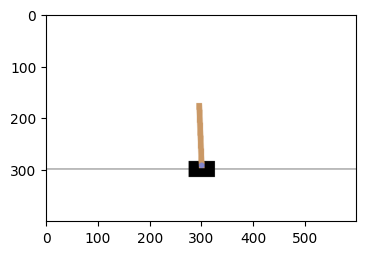

In [609]:
env_render = gym.make('CartPole-v1', render_mode='rgb_array', max_episode_steps=200)
env_render.reset(seed = 0)  # Forget about previous episode
state = env_render.reset(seed=0)[0].reshape((1, state_space_dimension))
print("STATE TO EXPLAIN: ", state)
state_tensor = torch.Tensor( state )
plt.imshow(env_render.render())
plt.show()

In [610]:
print("Shapley value of Cart Position: ", shapley_value(0))
print("Shapley value of Cart Velocity: ", shapley_value(1))
print("Shapley value of Pole Angle: ", shapley_value(2))
print("Shapley value of Pole Angular Velocity: ", shapley_value(3))

Shapley value of Cart Position:  49.66666666666667
Shapley value of Cart Velocity:  13.333333333333332
Shapley value of Pole Angle:  5.166666666666667
Shapley value of Pole Angular Velocity:  85.83333333333333
